In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# Load datasets
assessments = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/assessments.csv')
student_assessment = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/studentAssessment.csv')
student_info = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/studentInfo.csv')
vle = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/vle.csv')
courses = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/courses.csv')
student_registration = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/studentRegistration.csv')

#For student vle
# Initialize a counter for bad lines
bad_line_count = 0

# Define the bad line handler function
def bad_line_handler(line, line_number):
    global bad_line_count
    bad_line_count += 1
    print(f"Skipping line {line_number}: {line}")
    return None

# Read the CSV file using the custom bad line handler
student_vle = pd.read_csv(
    '/content/drive/MyDrive/OULAD-anonymisedData/studentVle.csv',
    engine='python',
    on_bad_lines=bad_line_handler
)

# Display the number of bad lines skipped
print(f'Number of bad lines skipped: {bad_line_count}')

Number of bad lines skipped: 0


In [10]:
# View Data Samples
print(courses.head())
print(assessments.head())
print(vle.head())
print(student_info.head())
print(student_registration.head())
print(student_assessment.head())
print(student_vle.head())

  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
3         BBB             2014J                         262
4         BBB             2013B                         240
  code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0
   id_site code_module code_presentation activity_type  week_from  week_to
0   546943         AAA             2013J      resource        NaN      NaN
1   546712         AAA

In [11]:
# Check for Missing Values
print(courses.isnull().sum())
print(assessments.isnull().sum())
print(vle.isnull().sum())
print(student_info.isnull().sum())
print(student_registration.isnull().sum())
print(student_assessment.isnull().sum())
print(student_vle.isnull().sum())

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64
code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64
id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64
code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64
code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64
id_assessment       0
id_student          0
da

In [12]:
# Step 1: Merge student_info with student_registration
student_data = pd.merge(
    student_info,
    student_registration,
    on=['code_module', 'code_presentation', 'id_student'],
    how='left'
)

# Step 2: Merge student_assessment with assessments
student_assessment_data = pd.merge(
    student_assessment,
    assessments,
    on=['id_assessment'],
    how='left'
)

# Step 3: Aggregate assessment data per student
student_assessment_agg = student_assessment_data.groupby('id_student').agg({
    'score': 'mean'
}).reset_index()
student_assessment_agg.rename(columns={'score': 'average_score'}, inplace=True)

# Step 4: Merge aggregated assessment data with student_data
student_data = pd.merge(
    student_data,
    student_assessment_agg,
    on='id_student',
    how='left'
)

# Step 5: Merge student_vle with vle to get activity_type
student_vle_activity = pd.merge(
    student_vle,
    vle[['id_site', 'activity_type']],
    on='id_site',
    how='left'
)

# Step 6: Aggregate sum_click per student and activity_type
student_vle_activity_agg = student_vle_activity.groupby(
    ['id_student', 'activity_type']
).agg({'sum_click': 'sum'}).reset_index()

# Step 7: Pivot to get activity types as columns
activity_pivot = student_vle_activity_agg.pivot_table(
    index='id_student',
    columns='activity_type',
    values='sum_click',
    fill_value=0
).reset_index()

# Step 8: Merge activity pivot with student_data
student_data = pd.merge(
    student_data,
    activity_pivot,
    on='id_student',
    how='left'
)


In [13]:
print(student_data.isnull().sum())

code_module                 0
code_presentation           0
id_student                  0
gender                      0
region                      0
highest_education           0
imd_band                 1111
age_band                    0
num_of_prev_attempts        0
studied_credits             0
disability                  0
final_result                0
date_registration          45
date_unregistration     22521
average_score            5866
dataplus                 2855
dualpane                 2855
externalquiz             2855
folder                   2855
forumng                  2855
glossary                 2855
homepage                 2855
htmlactivity             2855
oucollaborate            2855
oucontent                2855
ouelluminate             2855
ouwiki                   2855
page                     2855
questionnaire            2855
quiz                     2855
repeatactivity           2855
resource                 2855
sharedsubpage            2855
subpage   

In [14]:
# Identify activity type columns
activity_types = ['dataplus', 'dualpane', 'externalquiz', 'folder', 'forumng', 'glossary', 'homepage',
                  'htmlactivity', 'oucollaborate', 'oucontent', 'ouelluminate', 'ouwiki', 'page',
                  'questionnaire', 'quiz', 'repeatactivity', 'resource', 'sharedsubpage', 'subpage', 'url']

# Fill missing values in activity type columns with zeros
student_data[activity_types] = student_data[activity_types].fillna(0)


In [15]:
# Sum activity type columns to get 'sum_click'
student_data['sum_click'] = student_data[activity_types].sum(axis=1)


In [16]:
# Since we've filled missing values in activity types, 'sum_click' should not have missing values
# But to be safe, fill any missing 'sum_click' values with 0
student_data['sum_click'] = student_data['sum_click'].fillna(0)

# For other missing values, decide whether to fill or drop
# For example, 'imd_band' and 'average_score' have missing values
# You might choose to fill these or drop them depending on your analysis
# For now, let's fill 'imd_band' and 'average_score' with a placeholder or the mean/mode

# Fill missing 'imd_band' with a placeholder (e.g., 'Unknown')
student_data['imd_band'] = student_data['imd_band'].fillna('Unknown')

# Fill missing 'average_score' with the mean score
mean_score = student_data['average_score'].mean()
student_data['average_score'] = student_data['average_score'].fillna(mean_score)

# Similarly, handle 'date_registration' if needed
student_data['date_registration'] = student_data['date_registration'].fillna(student_data['date_registration'].median())

# Drop rows where 'final_result' is missing (though from your output, there are none)
student_data = student_data.dropna(subset=['final_result'])


In [17]:
print('sum_click' in student_data.columns)  # Should output: True
print(student_data['sum_click'].isnull().sum())  # Should output: 0


True
0


In [18]:
print(student_data.isnull().sum())


code_module                 0
code_presentation           0
id_student                  0
gender                      0
region                      0
highest_education           0
imd_band                    0
age_band                    0
num_of_prev_attempts        0
studied_credits             0
disability                  0
final_result                0
date_registration           0
date_unregistration     22521
average_score               0
dataplus                    0
dualpane                    0
externalquiz                0
folder                      0
forumng                     0
glossary                    0
homepage                    0
htmlactivity                0
oucollaborate               0
oucontent                   0
ouelluminate                0
ouwiki                      0
page                        0
questionnaire               0
quiz                        0
repeatactivity              0
resource                    0
sharedsubpage               0
subpage   

In [19]:
# Drop the 'date_unregistration' column
student_data = student_data.drop(columns=['date_unregistration'])


In [23]:
# **Merge student VLE interactions with VLE content**
material_usage = student_vle.merge(
    vle,
    on=['id_site', 'code_module', 'code_presentation'],
    how='left'
)

# **Group by student, module, presentation, and activity type**
material_usage = material_usage.groupby(
    ['id_student', 'code_module', 'code_presentation', 'activity_type']
).agg({'sum_click': 'sum'}).reset_index()

# **Pivot to get activity types as columns**
material_pivot = material_usage.pivot_table(
    index=['id_student', 'code_module', 'code_presentation'],
    columns='activity_type',
    values='sum_click',
    fill_value=0
).reset_index()


In [25]:
# Drop activity type columns from student_data
student_data = student_data.drop(columns=activity_types, errors='ignore')

# **Merge with student data**
student_data = pd.merge(
    student_data,
    material_pivot,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left'
)

# **Fill missing values in activity type columns**
activity_types = material_pivot.columns.tolist()
activity_types = [col for col in activity_types if col not in ['id_student', 'code_module', 'code_presentation']]
student_data[activity_types] = student_data[activity_types].fillna(0)

# **Add 'week' column to student_vle**
student_vle['week'] = student_vle['date'] // 7

# **Group total clicks per student, module, presentation, and week**
weekly_usage = student_vle.groupby(
    ['id_student', 'code_module', 'code_presentation', 'week']
).agg({'sum_click': 'sum'}).reset_index()

# **Pivot to get weeks as columns**
weekly_pivot = weekly_usage.pivot_table(
    index=['id_student', 'code_module', 'code_presentation'],
    columns='week',
    values='sum_click',
    fill_value=0
).reset_index()

# **Rename week columns for clarity**
week_columns = weekly_pivot.columns.tolist()
week_columns[3:] = [f'week_{int(week)}' for week in week_columns[3:]]
weekly_pivot.columns = week_columns

# **Merge weekly pivot with student data**
student_data = pd.merge(
    student_data,
    weekly_pivot,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left'
)

# **Fill missing values in week columns**
week_columns = [col for col in week_columns if col not in ['id_student', 'code_module', 'code_presentation']]
student_data[week_columns] = student_data[week_columns].fillna(0)

# **Update 'sum_click' column**
student_data['sum_click'] = student_data[activity_types].sum(axis=1)

# **Check uniqueness of composite keys**
assert student_data.duplicated(subset=['id_student', 'code_module', 'code_presentation']).sum() == 0, \
    "Duplicate entries found in student_data for the same student, module, and presentation."

In [26]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
categorical_cols = ['code_module', 'code_presentation', 'gender', 'region', 'highest_education',
                    'imd_band', 'age_band', 'disability', 'final_result']

# Encode categorical variables
for col in categorical_cols:
    le = LabelEncoder()
    student_data[col] = le.fit_transform(student_data[col].astype(str))


In [27]:
# Features (you can add more features as needed)
features = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability',
            'sum_click'] + list(material_pivot.columns[1:])

# Target variable
target = 'final_result'  # Encoded as numerical values


In [28]:
from sklearn.model_selection import train_test_split

X = student_data[features].fillna(0)
y = student_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [30]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6436570026077619
              precision    recall  f1-score   support

           0       0.54      0.10      0.18       593
           1       0.51      0.27      0.35      1495
           2       0.65      0.91      0.76      2458
           3       0.69      0.76      0.72      1973

    accuracy                           0.64      6519
   macro avg       0.60      0.51      0.50      6519
weighted avg       0.62      0.64      0.60      6519



In [35]:
# Predict on the entire dataset
student_data['predicted_result'] = model.predict(student_data[features])

# Find students predicted to fail or withdraw
at_risk_students = student_data[student_data['predicted_result'].isin([0, 1])]  # Assuming 0 and 1 correspond to 'Fail' and 'Withdrawn'

# **Define Activity Type Columns**
activity_types = ['dataplus', 'dualpane', 'externalquiz', 'folder', 'forumng', 'glossary',
                  'homepage', 'htmlactivity', 'oucollaborate', 'oucontent', 'ouelluminate',
                  'ouwiki', 'page', 'questionnaire', 'quiz', 'repeatactivity', 'resource',
                  'sharedsubpage', 'subpage', 'url']

# Recommend materials they have interacted with the least
def recommend_materials(row, activity_cols, num_recommendations=3):
    # Extract interactions for the specified activity columns
    material_interactions = row[activity_cols]

    # Find the least interacted materials
    least_used_materials = material_interactions.nsmallest(num_recommendations).index.tolist()
    return least_used_materials


# Apply the recommend_materials function to at-risk students
at_risk_students['recommended_materials'] = at_risk_students.apply(
    lambda row: recommend_materials(row, activity_types),
    axis=1
)

# View recommendations for a student
print(at_risk_students[['id_student', 'recommended_materials']].head())


    id_student               recommended_materials
18       74372  [dataplus, dualpane, externalquiz]
53      147756  [dataplus, dualpane, externalquiz]
76      185439  [dataplus, dualpane, externalquiz]
78      187100    [dualpane, externalquiz, folder]
86      205719  [dataplus, dualpane, externalquiz]


<ipython-input-35-ca118af8adc4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_risk_students['recommended_materials'] = at_risk_students.apply(


In [36]:
print(student_data.head())

   code_module  code_presentation  id_student  gender  region  \
0            0                  1       11391       1       0   
1            0                  1       28400       0       6   
2            0                  1       30268       0       5   
3            0                  1       31604       0       7   
4            0                  1       32885       0      11   

   highest_education  imd_band  age_band  num_of_prev_attempts  \
0                  1         9         2                     0   
1                  1         2         1                     0   
2                  0         3         1                     0   
3                  0         5         1                     0   
4                  2         5         0                     0   

   studied_credits  ...  week_30  week_31  week_32  week_33  week_34  week_35  \
0              240  ...     43.0     35.0      0.0     15.0     85.0      7.0   
1               60  ...     88.0      5.0     12.0

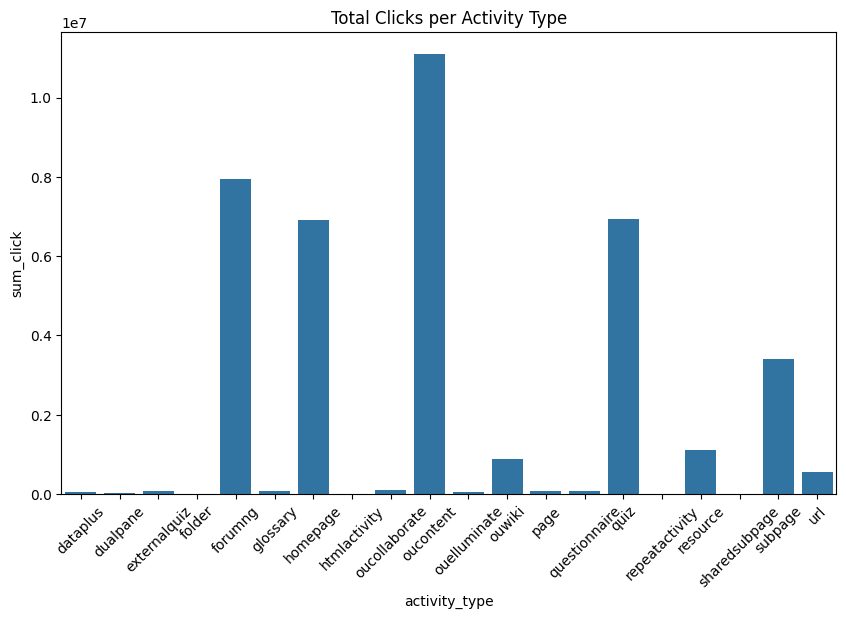

In [37]:
# Total clicks per activity type
activity_clicks = material_usage.groupby('activity_type').agg({'sum_click': 'sum'}).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='activity_type', y='sum_click', data=activity_clicks)
plt.title('Total Clicks per Activity Type')
plt.xticks(rotation=45)
plt.show()


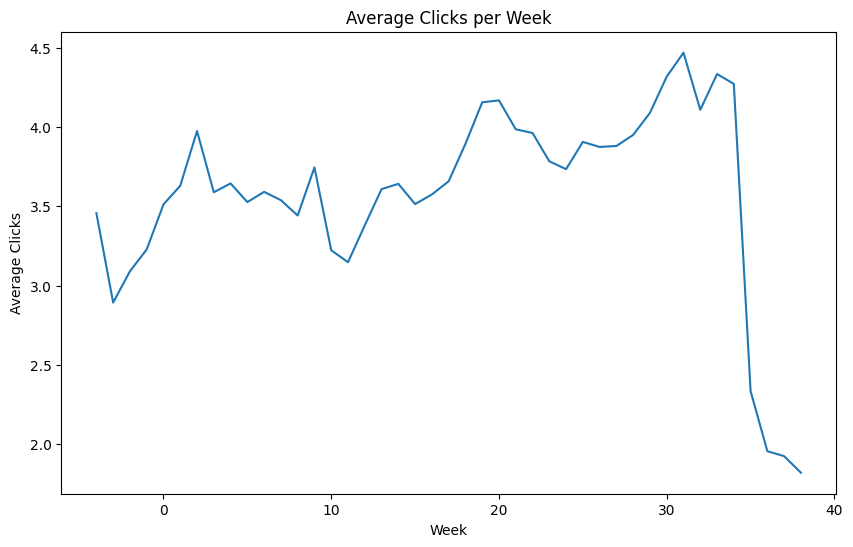

In [38]:
# Average clicks per week
weekly_clicks = student_vle.groupby('week').agg({'sum_click': 'mean'}).reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='week', y='sum_click', data=weekly_clicks)
plt.title('Average Clicks per Week')
plt.xlabel('Week')
plt.ylabel('Average Clicks')
plt.show()
